In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az

from skpro.regression.bayesian_wip import BayesianLinearRegression


This notebook serves to demonstrate the use of the `BayesianLinearRegression` regressor. This `skpro` class implements Bayesian linear regression using `PyMC` as a backend. It assumes weakly-informative Bayesian priors for both the intercepts and slopes of the model.

Compared to a traditional OLS Linear Regression,  Bayesian Linear Regression offers several benefits:

1. It provides full posterior distributions of model parameters, allowing for direct assessment of uncertainty in predictions.
2. It enables the inclusion of prior information or beliefs about parameters, improving estimates when data is limited.
3. It regularizes parameter estimates through priors, reducing overfitting compared to traditional linear regression.


## Data Generation

We will first create a synthetic data

In [2]:
# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 100, 100)
X = pd.DataFrame({'feature1': X, 'feature2': X**2})  # Example with two features
true_intercepts = 1
true_slopes = np.array([2, -1])  # True coefficients for feature1 and feature2
true_sigma = 0.1
y = true_intercepts + np.dot(X, true_slopes) + np.random.normal(0, true_sigma, size=len(X))
y = pd.DataFrame(y, columns = ["target"])

In [3]:
X.head()

,feature1,feature2
0,0.000000,0.000000
1,1.010101,1.020304
2,2.020202,4.081216
3,3.030303,9.182736
4,4.040404,16.324865


In [4]:
y.head()

,target
0,1.049671
1,1.986072
2,1.023957
3,-1.969827
4,-7.267472


In [5]:
# Generate new data points for prediction
X_new = pd.DataFrame({'feature1': np.linspace(1, 50, 50), 'feature2': 1})
X_new.head()

,feature1,feature2
0,1.0,1
1,2.0,1
2,3.0,1
3,4.0,1
4,5.0,1


We then create an instance of the `BayesianLinearRegression` and fit it with our training data.

In [6]:
%timeit
model = BayesianLinearRegression()
model.fit(X, y)

# Model checking

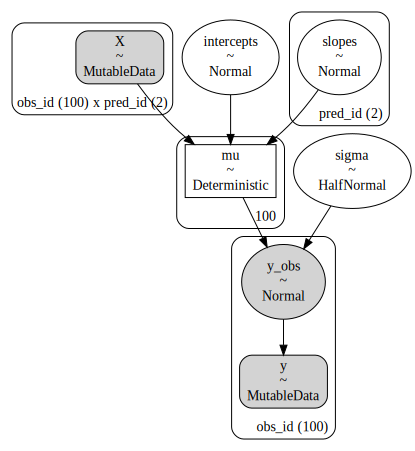

In [7]:
model.visualize_model()

# Predictions

Given a fresh set of test data `X_new`, we can get point predictions using the `predict` method.

In [8]:
mean_predictions = model.predict(X_new)
mean_predictions.head()

,target
obs_id,
0,0.986227
1,0.983692
2,0.987381
3,0.986519
4,0.985443


Alternatively, we can obtain the posterior predictive distribution for each data point in `X_new` using the `predict_proba` method.

Note: The posterior predictive distribution is a distribution of predicted target values given a set of observed data. It incorporates the uncertainty in the model parameters by integrating over the posterior distribution of the parameters. Mathematically, the posterior predictive distribution is given by:
$$
p(y_{\text{pred}} | X_{\text{new}}, \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}) = \int p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta}) p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}}) \, d\mathbf{\theta}
$$

where:
- $y_{\text{pred}}$ is the new predicted data point.
- $X_{\text{new}}$ is the new input.
- $\mathbf{X}_{\text{train}}$ is the set of observed inputs.
- $\mathbf{y}_{\text{train}}$ is the set of observed outputs.
- $\mathbf{\theta}$ represents the model parameters.
- $p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta})$ is the likelihood of the new data point given the model parameters.
- $p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$ is the posterior distribution of the model parameters given the observed data.

The posterior predictive distribution thus accounts for the uncertainty in the parameters by averaging the likelihood $p(y_{\text{pred}} | X_{\text{new}}, \mathbf{\theta})$ over the posterior distribution of the parameters $p(\mathbf{\theta} | \mathbf{X}_{\text{train}}, \mathbf{y}_{\text{train}})$.

Note that this posterior predictive distribution is returned by `predict_proba` as an xarray DataArray, allowing us to easily plot the results or compute summary statistics such as means, percentiles, and credible intervals.

In [9]:
predict_proba = model.predict_proba(X_new)

In [10]:
predict_proba

<xarray.DataArray 'y_obs' (chain: 1, draw: 2000, obs_id: 50)>
array([[[  2.90819869,   4.17953503,   5.38214984, ...,  61.82284529,
          63.06312322,  64.19782556],
        [ -1.58903552,  -2.70163151,  -3.97064121, ..., -64.47375776,
         -65.615485  , -66.99784199],
        [  0.16621532,   1.51332295,   2.73401697, ...,  63.17478991,
          64.75852273,  65.76898938],
        ...,
        [  1.83138227,   2.97761083,   4.12161047, ...,  59.84917721,
          61.08815253,  62.48395636],
        [  0.42235325,  -0.14596321,  -0.78837251, ..., -29.68464821,
         -30.29557345, -30.91119145],
        [  0.17610928,  -1.43831733,  -3.34122786, ..., -82.72257485,
         -84.46072474, -86.50860871]]])
Coordinates:
  * chain    (chain) int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 ... 1993 1994 1995 1996 1997 1998 1999
  * obs_id   (obs_id) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49

We can also perform quantile predictions using the `predict_quantile` method.

In [11]:
quantile_df = model.predict_quantile(X_new, alpha = [0.25, 0.5, 0.75])
quantile_df.head()

target                    
       0.25      0.50      0.75
0  0.038228  0.967994  1.995604
1 -0.592770  0.975328  2.538072
2 -1.274662  0.984112  3.168724
3 -1.913709  0.950016  3.871534
4 -2.659120  0.976864  4.575994

We can also

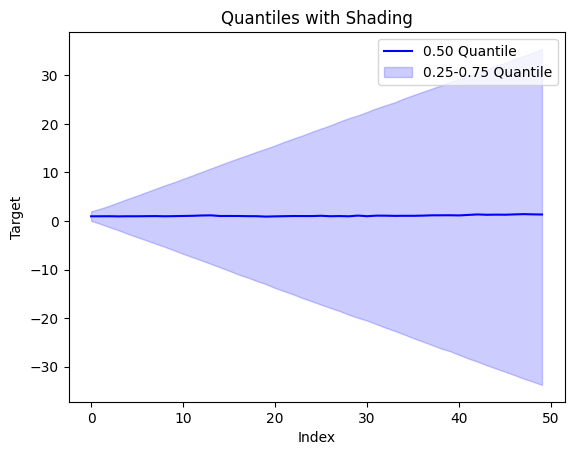

In [15]:
model.plot_posterior_predictive(X_new)

## Getting Parameters

Here, we see that the model manages to recover the real slope of 2 and -1.

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([[<Axes: title={'center': 'slopes'}>,
        <Axes: title={'center': 'slopes'}>]], dtype=object)

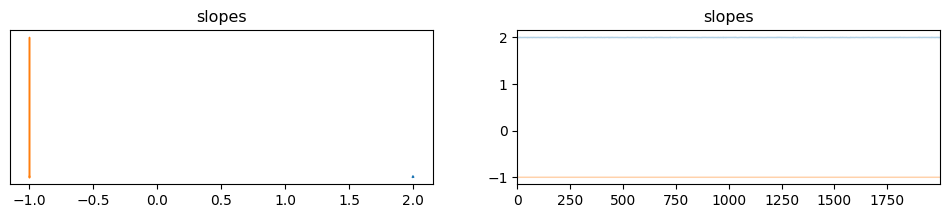

In [16]:
az.plot_trace(model.trace.posterior["slopes"])